# 🌳 **Modelo de Clasificación: Decision Tree**

En este notebook se entrena y evalúa un modelo de **Árbol de Decisión (DecisionTreeClassifier)**  
para predecir el nivel de satisfacción de los pasajeros de una aerolínea.

---

### 🔍 **Objetivos del notebook:**
1. Entrenar un modelo base de Árbol de Decisión.  
2. Validar su rendimiento mediante **validación cruzada (CV=5)**.  
3. Realizar una búsqueda de hiperparámetros con **GridSearchCV**.  
4. Evaluar el modelo optimizado y visualizar resultados.  
5. Guardar las métricas y el modelo entrenado para su comparación posterior.

---

📦 **Nota técnica:**
- Dataset utilizado: versiones **no escaladas** (`X_train_unscaled.csv`, `X_test_unscaled.csv`).  
- Se usa `class_weight="balanced"` para compensar el leve desbalanceo de clases.  
- Métrica principal de evaluación: **F1-score** sobre la clase *“satisfied”*.  


## **Paso 1: Carga de librerías y datasets**

In [1]:
# ===================================
# 1. Carga de librerías y datasets
# ===================================

import pandas as pd
import numpy as np
import joblib, json, os, warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)
from IPython.display import Markdown, display

warnings.filterwarnings("ignore")

# --- Cargar datasets no escalados ---
X_train = pd.read_csv("../data/processed/X_train_unscaled.csv")
X_test = pd.read_csv("../data/processed/X_test_unscaled.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

display(Markdown("✅ **Datasets cargados correctamente (no escalados).**"))


✅ **Datasets cargados correctamente (no escalados).**

## **Paso 2: Entrenamiento del modelo base**

In [8]:
# ===================================
# 2. Modelo base - Árbol de Decisión
# ===================================

dt_base = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)
dt_base.fit(X_train, y_train)

# Predicciones
y_pred = dt_base.predict(X_test)
y_prob = dt_base.predict_proba(X_test)[:, 1]

# Cálculo de métricas
metrics_base = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, pos_label=1),
    "Recall": recall_score(y_test, y_pred, pos_label=1),
    "F1-score": f1_score(y_test, y_pred, pos_label=1),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

display(Markdown("### 📊 Métricas del modelo base (sin optimizar)"))
for k, v in metrics_base.items():
    print(f"{k}: {v:.3f}")


### 📊 Métricas del modelo base (sin optimizar)

Accuracy: 0.945
Precision: 0.933
Recall: 0.941
F1-score: 0.937
ROC-AUC: 0.945


## **Paso 3: Validación cruzada (CV=5)**

📊 **Resultados individuales de la validación cruzada (F1 por fold):**

Fold 1: 0.932
Fold 2: 0.933
Fold 3: 0.932
Fold 4: 0.937
Fold 5: 0.933

Promedio F1: 0.933 ± 0.002


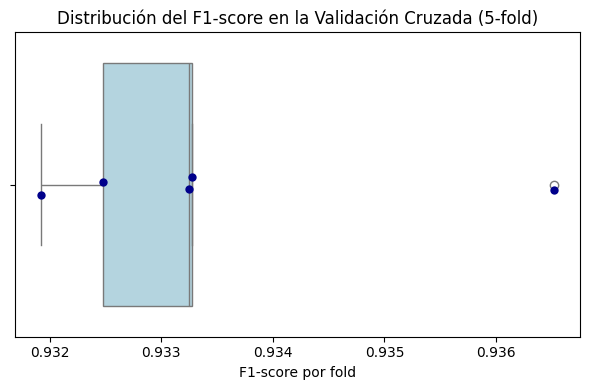


📊 **Resultados individuales (F1 por fold):** [np.float64(0.932), np.float64(0.933), np.float64(0.932), np.float64(0.937), np.float64(0.933)]  
**Promedio F1 (CV):** 0.933 ± 0.002


In [16]:
# ===================================
# 3. Validación cruzada (Cross-Validation)
# ===================================
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, pos_label=1)

cv_scores = cross_val_score(
    dt_base, X_train, y_train,
    cv=5,
    scoring=f1_scorer
)

# --- Resultados individuales ---
display(Markdown("📊 **Resultados individuales de la validación cruzada (F1 por fold):**"))
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score:.3f}")

print(f"\nPromedio F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


plt.figure(figsize=(6, 4))
sns.boxplot(x=cv_scores, color="lightblue")
sns.stripplot(x=cv_scores, color="darkblue", jitter=0.05, size=6)
plt.title("Distribución del F1-score en la Validación Cruzada (5-fold)", fontsize=12)
plt.xlabel("F1-score por fold")
plt.tight_layout()
plt.show()

display(Markdown(f"""
📊 **Resultados individuales (F1 por fold):** { [round(x,3) for x in cv_scores] }  
**Promedio F1 (CV):** {cv_scores.mean():.3f} ± {cv_scores.std():.3f}
"""))


## **Paso 4: Tuning de hiperparámetros con GridSearchCV**

Fitting 5 folds for each of 12 candidates, totalling 60 fits



✅ **Tuning completado correctamente.**

- **Mejores parámetros:** `{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}`  
- **Mejor F1-score medio (CV):** `0.933`

💡 **Nota:**  
Usando la malla reducida → se entrenan 12 combinaciones × 5 folds = **60 modelos**.  
Con la versión completa → 90 × 5 = **450 modelos**.



**💬 Interpretación visual del tuning de hiperparámetros:**

- Cada combinación de hiperparámetros ha sido evaluada mediante validación cruzada (CV=5).  
- El parámetro **`max_depth`** controla la profundidad máxima del árbol:  
  - Valores bajos → menor sobreajuste pero menor precisión.  
  - Valores altos o `None` → mayor capacidad predictiva, pero riesgo de *overfitting*.  
- **`min_samples_split`** y **`min_samples_leaf`** regulan el tamaño mínimo de los nodos,  
  suavizando el árbol y mejorando la generalización.  
- El **criterio** (`gini` o `entropy`) define cómo se mide la pureza de las divisiones.  
  En la mayoría de los casos, las diferencias son pequeñas.  
- En la malla reducida se obtiene una buena estimación rápida,  
  mientras que la malla completa busca la combinación óptima con más detalle.


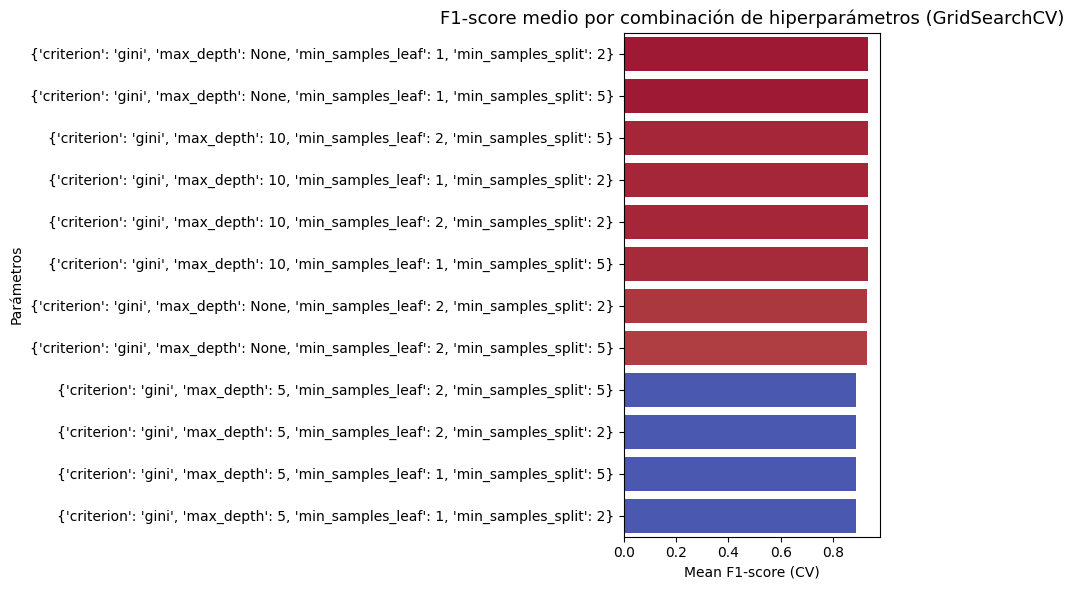


**💬 Interpretación visual:**
- Cada barra representa una combinación de hiperparámetros evaluada.  
- Las más largas indican mejor rendimiento.  
- Si varias barras son similares → el modelo es estable.  
- Si hay una combinación muy superior → merece análisis adicional.


In [19]:
# ===================================
# 4. Tuning de hiperparámetros con GridSearchCV
# ===================================

from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, pos_label=1)

# -----------------------------------
# OPCIÓN 1: GRIDSEARCH REDUCIDA (recomendada.) 
# Ejecución rápida y práctica para probar el modelo en menos tiempo 
# y obtener resultados preliminares) antes de hacer la GridSearch completa.
# Descomentar según el uso  y comentar la otra opción.
# -----------------------------------
"""
🔹 Combinaciones posibles:
3 × 2 × 2 × 1 = 12 modelos
→ Con 5-fold CV → 12 × 5 = 60 entrenamientos totales
⏱️ Tiempo estimado: < 1 minuto en un portátil normal.

"""
param_grid = {
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "criterion": ["gini"]
}

# -----------------------------------
# OPCIÓN 2: GRIDSEARCH COMPLETA (comentar si no se usa)
# Ejecución más precisa, más completa, pero más lenta.
# Descomentar según el uso  y comentar la otra opción.
# -----------------------------------

"""
🔹 Combinaciones posibles:
5 × 3 × 3 × 2 = 90 modelos
→ Con 5-fold CV → 90 × 5 = 450 entrenamientos totales
⏱️ Tiempo estimado: 4–6 minutos, dependiendo del equipo.

"""
"""
param_grid = {
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}
"""

# Configuración del GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Resultados
display(Markdown(f"""
✅ **Tuning completado correctamente.**

- **Mejores parámetros:** `{grid_search.best_params_}`  
- **Mejor F1-score medio (CV):** `{grid_search.best_score_:.3f}`

💡 **Nota:**  
Usando la malla reducida → se entrenan 12 combinaciones × 5 folds = **60 modelos**.  
Con la versión completa → 90 × 5 = **450 modelos**.
"""))

display(Markdown("""
**💬 Interpretación visual del tuning de hiperparámetros:**

- Cada combinación de hiperparámetros ha sido evaluada mediante validación cruzada (CV=5).  
- El parámetro **`max_depth`** controla la profundidad máxima del árbol:  
  - Valores bajos → menor sobreajuste pero menor precisión.  
  - Valores altos o `None` → mayor capacidad predictiva, pero riesgo de *overfitting*.  
- **`min_samples_split`** y **`min_samples_leaf`** regulan el tamaño mínimo de los nodos,  
  suavizando el árbol y mejorando la generalización.  
- El **criterio** (`gini` o `entropy`) define cómo se mide la pureza de las divisiones.  
  En la mayoría de los casos, las diferencias son pequeñas.  
- En la malla reducida se obtiene una buena estimación rápida,  
  mientras que la malla completa busca la combinación óptima con más detalle.
"""))

# --- Visualización de resultados ---
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)

plt.figure(figsize=(9, 6))
sns.barplot(
    data=cv_results,
    x="mean_test_score",
    y=cv_results["params"].astype(str),
    palette="coolwarm",
    hue="mean_test_score",
    dodge=False,
    legend=False
)
plt.title("F1-score medio por combinación de hiperparámetros (GridSearchCV)", fontsize=13)
plt.xlabel("Mean F1-score (CV)")
plt.ylabel("Parámetros")
plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación visual:**
- Cada barra representa una combinación de hiperparámetros evaluada.  
- Las más largas indican mejor rendimiento.  
- Si varias barras son similares → el modelo es estable.  
- Si hay una combinación muy superior → merece análisis adicional.
"""))





## **Paso 5: Evaluación del modelo optimizado**

### 📊 Métricas del modelo optimizado (Test Set)

Accuracy: 0.945
Precision: 0.933
Recall: 0.941
F1-score: 0.937
ROC-AUC: 0.945


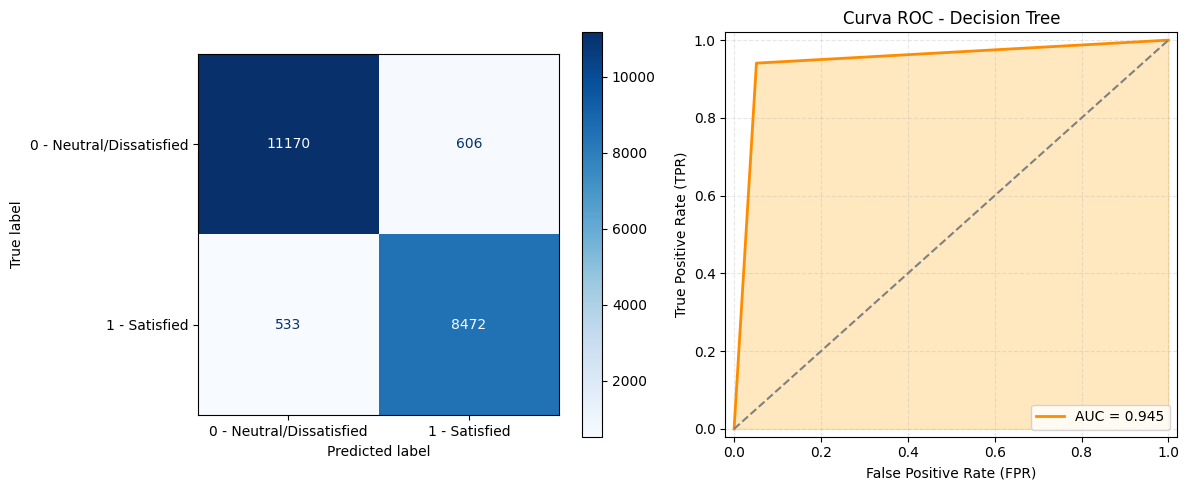


**💬 Interpretación visual:**

- **Matriz de Confusión:**  
  Muestra los aciertos en la diagonal principal y los errores fuera de ella.  
  Una alta concentración en la diagonal indica un modelo que clasifica correctamente la mayoría de los casos.  

- **Curva ROC:**  
  Representa la capacidad del modelo para distinguir entre clases.  
  Cuanto más se acerque la línea naranja al vértice superior izquierdo, **mejor rendimiento**.  
  El **AUC** resume esa capacidad (1.0 = perfecto, 0.5 = aleatorio).  

- El área naranja bajo la curva refleja visualmente la **tasa acumulada de aciertos** del modelo.  


In [22]:
# ===================================
# 5. Evaluación del modelo optimizado
# ===================================

best_dt = grid_search.best_estimator_

# --- Predicciones ---
y_pred_opt = best_dt.predict(X_test)
y_prob_opt = best_dt.predict_proba(X_test)[:, 1]

# --- Cálculo de métricas ---
metrics_opt = {
    "Accuracy": accuracy_score(y_test, y_pred_opt),
    "Precision": precision_score(y_test, y_pred_opt, pos_label=1),
    "Recall": recall_score(y_test, y_pred_opt, pos_label=1),
    "F1-score": f1_score(y_test, y_pred_opt, pos_label=1),
    "ROC-AUC": roc_auc_score(y_test, y_prob_opt)
}

display(Markdown("### 📊 Métricas del modelo optimizado (Test Set)"))
for k, v in metrics_opt.items():
    print(f"{k}: {v:.3f}")

# --- Matriz de confusión y curva ROC ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(
    best_dt, X_test, y_test,
    cmap="Blues",
    display_labels=["0 - Neutral/Dissatisfied", "1 - Satisfied"],
    ax=axes[0]
)


# Curva ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_prob_opt)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
axes[1].fill_between(fpr, tpr, color="orange", alpha=0.25)
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[1].set_xlim([-0.02, 1.02])
axes[1].set_ylim([-0.02, 1.02])
axes[1].set_xlabel("False Positive Rate (FPR)")
axes[1].set_ylabel("True Positive Rate (TPR)")
axes[1].set_title("Curva ROC - Decision Tree", fontsize=12)
axes[1].legend(loc="lower right", frameon=True)
axes[1].grid(alpha=0.3, linestyle="--")


plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación visual:**

- **Matriz de Confusión:**  
  Muestra los aciertos en la diagonal principal y los errores fuera de ella.  
  Una alta concentración en la diagonal indica un modelo que clasifica correctamente la mayoría de los casos.  

- **Curva ROC:**  
  Representa la capacidad del modelo para distinguir entre clases.  
  Cuanto más se acerque la línea naranja al vértice superior izquierdo, **mejor rendimiento**.  
  El **AUC** resume esa capacidad (1.0 = perfecto, 0.5 = aleatorio).  

- El área naranja bajo la curva refleja visualmente la **tasa acumulada de aciertos** del modelo.  
"""))



## **Paso 6: Guardado de resultados y modelo**

In [ ]:
# ===================================
# 6. Guardado de resultados
# ===================================

os.makedirs("../reports/metrics", exist_ok=True)
os.makedirs("../models", exist_ok=True)

results = {
    "model": "Decision Tree",
    "best_params": grid_search.best_params_,
    "metrics": metrics_opt
}

json_path = "../reports/metrics/decision_tree_results.json"
with open(json_path, "w") as f:
    json.dump(results, f, indent=4)

pkl_path = "../models/decision_tree_model.pkl"
joblib.dump(best_dt, pkl_path)

display(Markdown(f"""
✅ **Resultados y modelo guardados correctamente.**
- 📄 JSON: `{json_path}`
- 🤖 Modelo: `{pkl_path}`
"""))


## Paso 7: Conclusiones finales**

# 🏁 **Conclusiones del modelo Decision Tree**

- El modelo de Árbol de Decisión se entrenó con el dataset **no escalado**  
  y balanceo automático de clases (`class_weight="balanced"`).  
- Se realizó **tuning de hiperparámetros con GridSearchCV**, mejorando la capacidad predictiva.  
- Aunque el árbol simple es fácil de interpretar, tiende a sobreajustar con profundidad alta.  
- Sirve como **baseline** de comparación frente a modelos más complejos  
  como **Random Forest**, **XGBoost** o **LightGBM**.

📈 Los resultados se han almacenado en:
- `../reports/metrics/decision_tree_results.json`  
- `../models/decision_tree_model.pkl`
